# Overview of the Knife-Edge Method

The Knife-Edge method is a simple and effective way to measure the width of a laser beam, especially when dealing with Gaussian beams. In this method, a sharp blade (the "knife edge") is moved across the laser beam, and the transmitted power (or intensity) of the beam is measured as a function of the knife-edge position. The result is a power-vs-position curve, from which the beam's width can be determined.

##  How it Works? 

- A knife-edge (usually a straight edge) is moved perpendicular to the propagation axis of the laser beam.
- As the knife-edge blocks part of the beam, the power (or intensity) reaching a detector decreases.
- The power is recorded at various positions of the knife-edge as it moves across the beam.
- From the recorded power values, it is possible to obtain the waist of the beam by curve fitting the cumulative Gaussian distribution

## Gaussian beams and Cumulative Gaussian function


The transverse intensity $I(x)$ of a Gaussian beam can be described as 

$$ I(x) = I_0 \exp \left[-\frac{2 x^2}{w_0^2}\right]$$


where $I_0$ is the peak intensity at the beam center and $w_0$ is the beam waist (radius). 

Let us consider the scenario in which we place a power meter on the beam's path. As the knife moves thorough the beam, it progressively blocks the intensity profile, changing the amount of power that the detector registers. It is easy to see that the recorded power follows a cumulative Gaussian distribution

$$ \Phi(x)=I_0\int_{x}^{\infty} \exp \left[-\frac{2 x^2}{w_0^2}\right] dx$$

Animation shown below, depicts the normalized power measured by the detector as we move the sharp knife-edge. 


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import ipywidgets as widgets
from ipywidgets import interact, interactive_output
from IPython.display import display

# Gaussian function definition
def gaussian(x, mean, sigma):
    return np.exp(- (x - mean) ** 2 / (2 * sigma ** 2))

# Cumulative Gaussian (Error Function) definition
def cumulative_gaussian(x, mean, sigma):
    return 0.5 * (1 - erf((x - mean) / (np.sqrt(2) * sigma)))

# Plotting function that updates based on slider values
def plot_gaussian_and_cumulative(x_pos=0.0, mean=0.0, sigma=1.0):
    x = np.linspace(-5, 5, 400)
    
    # Compute Gaussian and cumulative Gaussian values
    gauss = gaussian(x, mean, sigma)
    cum_gauss = cumulative_gaussian(x, mean, sigma)
    
    # Create the figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))  # Adjust figure size to make it wider
    
    # Plot Gaussian distribution
    ax[0].plot(x, gauss, label="Gaussian Beam Profile")
    ax[0].axvline(x=x_pos, color='r', linestyle='--', label=f"Knife-edge at x={x_pos}")
    
    # Create the rectangle to represent the knife-edge blocking the beam
    ax[0].fill_between(x, 0, gauss, where=(x <= x_pos), color='red', alpha=0.3, label="Blocked by Knife-edge")
    ax[0].add_patch(plt.Rectangle((-5, 0), x_pos + 5, 1, color='Black', alpha=0.7, label="Knife-edge Area"))

    ax[0].set_title('Gaussian Beam Profile with Knife-edge Block')
    ax[0].set_xlabel('Position (x)')
    ax[0].set_ylabel('Intensity')
    ax[0].legend(loc='upper right')
    
    # Plot cumulative Gaussian (error function)
    ax[1].plot(x, cum_gauss, label="Cumulative Power (Error Function)")
    ax[1].axvline(x=x_pos, color='r', linestyle='--', label=f"Knife-edge at x={x_pos}")
    ax[1].set_title('Cumulative Power vs Knife-edge Position')
    ax[1].set_xlabel('Position (x)')
    ax[1].set_ylabel('Cumulative Power')
    ax[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Create widgets for sliders with wider layout
slider_layout = widgets.Layout(width='70%')  # Set wider width for sliders
x_pos_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Knife-edge Position', layout=slider_layout)
mean_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mean', layout=slider_layout)
sigma_slider = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Sigma', layout=slider_layout)

# Output widget for the plot
output = widgets.Output()

# Function to update the plot and display it in the output widget
def update_plot(x_pos, mean, sigma):
    with output:
        output.clear_output(wait=True)  # Clear the previous plot
        plot_gaussian_and_cumulative(x_pos, mean, sigma)

# Use interactive_output to connect the sliders to the update_plot function
interactive_plot = interactive_output(update_plot, {'x_pos': x_pos_slider, 'mean': mean_slider, 'sigma': sigma_slider})

# Display the sliders and the plot below them
display(widgets.VBox([x_pos_slider, mean_slider, sigma_slider, output]))


Therefore, it is possible to extract the width of the Gaussian beam at the measuring plane by fitting the recorded data to the expression

$$P(x)= \frac{A}{2} \left[ 1-\text{erf}\left(\frac{x-x0}{w_0}\right)\right]+B $$

where $P(x)$ corresponds to the measured power after a the knife has been displaced a distance $x$, $x_0$ is the position of the beam center, $w_0$ is the beam radius (not the waist). $A$ is scaling factor for the total power while $B$ is an offset to account for the backgroud power. 




Fitted center position x0 [cm]: 0.1500
Calculated beam width [cm]: 0.0408


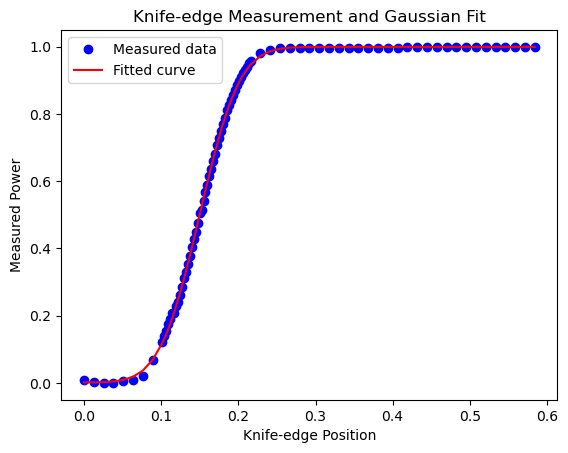

In [71]:

# Define the error function, which is the integral of a Gaussian
def error_function(x, x0, w, A, B):
    return A * 0.5 * (1 + erf((x - x0) / (np.sqrt(2) * w))) + B

# Import the Data Array
data = np.loadtxt("C:/Users/mferrerg/Documents/Try1.csv", delimiter=',', skiprows=0, encoding='utf-8-sig')

knife_edge_positions = data[:,0]
measured_powers =1 - data[:,1]/np.max(data[:,1])

# Initial guess for the parameters: [x0, w, A, B]
initial_guess = [0.5, 0.1, 1.0, 0.0]

# Fit the error function to the data
params, covariance = curve_fit(error_function, knife_edge_positions, measured_powers, p0=initial_guess)

# Extract the fitted parameters
x0, w, A, B = params

# Calculate the beam width (1/e² width)
beam_width = w

# Print the results
print(f"Fitted center position x0 [cm]: {x0:.4f}")
print(f"Calculated beam width [cm]: {beam_width:.4f}")

# Plot the data and the fitted curve
plt.figure()
plt.plot(knife_edge_positions, measured_powers, 'bo', label='Measured data')
plt.plot(knife_edge_positions, error_function(knife_edge_positions, *params), 'r-', label='Fitted curve')
plt.xlabel('Knife-edge Position')
plt.ylabel('Measured Power')
plt.title('Knife-edge Measurement and Gaussian Fit')
plt.legend()
plt.show()
